#Introduction

This notebook focuses on forecasting weekly sales for various Walmart stores using the Chronos deep learning model. We begin by loading and preparing the sales data, converting it into a time series format suitable for Chronos, and applying a log transformation to optimize model performance. The core achievement is leveraging the Chronos model to generate 4 week ahead sales predictions, complete with confidence intervals. We then rigorously evaluate these forecasts using metrics like MAE, RMSE, and MAPE, revealing that while the model exhibits exceptional accuracy for some stores (e.g., MAPE under 2% for Store 30 and 33), performance varies

##Loading the Dataset

In [1]:
import pandas as pd, os


In [2]:
CSV_PATH = "/content/drive/MyDrive/WALMART_SALES_DATA.csv"

In [3]:
df = pd.read_csv(CSV_PATH)

##Handle Missing Values

In [4]:
print("Missing values count per column:")
print(df.isnull().sum())

print("\nPercentage of missing values per column:")
print((df.isnull().sum() / len(df)) * 100)

print("\nData types of all columns:")
print(df.dtypes)

Missing values count per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Percentage of missing values per column:
Store           0.0
Date            0.0
Weekly_Sales    0.0
Holiday_Flag    0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
dtype: float64

Data types of all columns:
Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object


##Handle Outliers

In [5]:
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

outliers = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]

print(f"First Quartile (Q1): {Q1}")
print(f"Third Quartile (Q3): {Q3}")
print(f"Interquartile Range (IQR): {IQR}")
print(f"Upper Bound for Outliers: {upper_bound}")
print(f"Lower Bound for Outliers: {lower_bound}")
print(f"\nNumber of outliers detected: {len(outliers)}")
print("\nFirst 5 outliers (if any):\n", outliers.head())

First Quartile (Q1): 553350.105
Third Quartile (Q3): 1420158.66
Interquartile Range (IQR): 866808.5549999999
Upper Bound for Outliers: 2720371.4924999997
Lower Bound for Outliers: -746862.7275

Number of outliers detected: 34

First 5 outliers (if any):
      Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
189      2  24-12-2010    3436007.68             0        49.97       2.886   
241      2  23-12-2011    3224369.80             0        46.66       3.112   
471      4  26-11-2010    2789469.45             1        48.08       2.752   
474      4  17-12-2010    2740057.14             0        46.57       2.884   
475      4  24-12-2010    3526713.39             0        43.21       2.887   

            CPI  Unemployment  
189  211.064660         8.163  
241  218.999550         7.441  
471  126.669267         7.127  
474  126.879484         7.127  
475  126.983581         7.127  


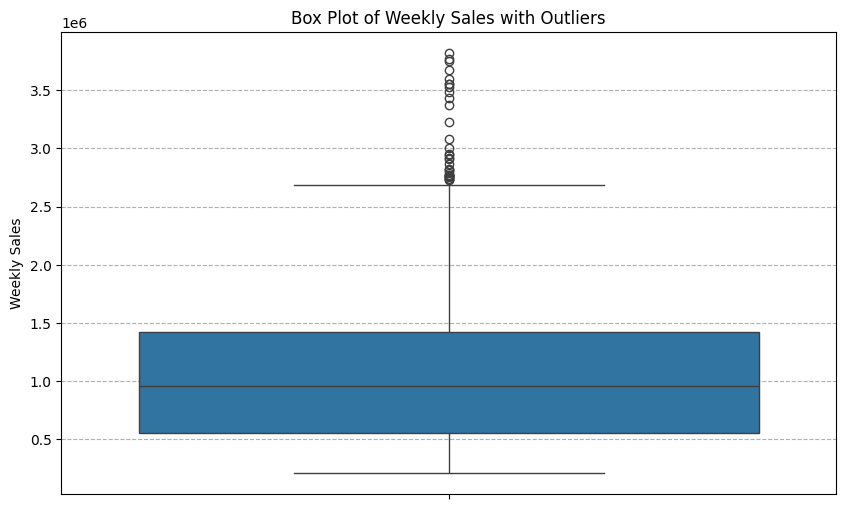

Box plot showing the distribution of Weekly_Sales and detected outliers.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Weekly_Sales'])
plt.title('Box Plot of Weekly Sales with Outliers')
plt.ylabel('Weekly Sales')
plt.grid(axis='y', linestyle='--')
plt.show()
print("Box plot showing the distribution of Weekly_Sales and detected outliers.")

##Load → convert to WEEKLY

In [37]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

df_weekly = (
    df.groupby(["Store", pd.Grouper(key="Date", freq="W")])["Weekly_Sales"]
      .sum()
      .reset_index()
      .sort_values(["Store", "Date"])
)


##Log transform target (MUCH better for Chronos)

In [38]:
df_weekly["Sales_Log"] = np.log1p(df_weekly["Weekly_Sales"])

##Build Chronos time series format

In [39]:
time_series_data = []
for store_id, store_df in df_weekly.groupby("Store"):
    store_df = store_df.sort_values("Date")
    ts = {
        "item_id": store_id,
        "start": store_df["Date"].iloc[0],
        "target_values": torch.tensor(store_df["Sales_Log"].values, dtype=torch.float32),
    }
    time_series_data.append(ts)

##Chronos Installation

In [17]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-zuylxqps
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-zuylxqps
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 67a6f91aec23ddbd8a256270af9491a4ad1b570d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for chronos-forecasting: filename=chronos_forecasting-2.1.0rc1-py3-none-any.whl size=70496 sha256=cbd261172e40caa3d11d1e4bc3a91c2ece7491e0f6a72d688c31442436506e7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hox356p/wheels/b9/a6/b5/75fca7306751a

In [18]:
from chronos import ChronosPipeline

In [19]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",

)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.model.to(device)

ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 384)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 384)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=384, out_features=512, bias=False)
                (k): Linear(in_features=384, out_features=512, bias=False)
                (v): Linear(in_features=384, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=384, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=384, out_features=1536, bias=False)
                (wo): Linear(in_features=

In [41]:
prediction_length = 4     # 4 weeks ahead
num_samples = 200         # number of forecast samples

##Forecast weekly (log space → then invert)

In [45]:
all_store_forecasts = []

for ts in time_series_data:
    target = ts["target_values"]

    forecast = pipeline.predict(
        inputs=[target],
        prediction_length=prediction_length,
        num_samples=num_samples
    )
#forecast is list → take first element
    samples_log = forecast[0].numpy()     # shape: [200 samples, 4 weeks]

    # Invert log1p
    samples = np.expm1(samples_log)
    # Compute stats
    mean_fc = samples.mean(axis=0)
    low_fc  = np.percentile(samples, 5, axis=0)
    high_fc = np.percentile(samples, 95, axis=0)

    all_store_forecasts.append({
        "store_id": ts["item_id"],
        "mean": mean_fc,
        "low": low_fc,
        "high": high_fc
    })

# =====================================================
# 6. Print
# =====================================================
for fc in all_store_forecasts:
    print("\nStore:", fc["store_id"])
    print("Weekly forecast (mean):", fc["mean"])




Store: 1
Weekly forecast (mean): [1593217.2 1637494.2 1734302.8 1776469.5]

Store: 2
Weekly forecast (mean): [1923971.  1993336.5 2018878.5 2122726. ]

Store: 3
Weekly forecast (mean): [449551.38 476146.6  473370.44 489994.28]

Store: 4
Weekly forecast (mean): [2249958. 2332353. 2327278. 2392990.]

Store: 5
Weekly forecast (mean): [337759.4  365964.62 370822.47 392499.72]

Store: 6
Weekly forecast (mean): [1542082.4 1759299.2 1749650.8 1859009.5]

Store: 7
Weekly forecast (mean): [512561.25 536773.2  570293.06 591080.1 ]

Store: 8
Weekly forecast (mean): [ 926166.06  957843.8  1015804.5  1072726.4 ]

Store: 9
Weekly forecast (mean): [563041.75 604944.4  618052.8  679583.2 ]

Store: 10
Weekly forecast (mean): [1901204.  2229849.5 2340072.8 2396902.8]

Store: 11
Weekly forecast (mean): [1269297.5 1324697.8 1372781.8 1453399.4]

Store: 12
Weekly forecast (mean): [ 988744.3 1111355.9 1241853.5 1531783.9]

Store: 13
Weekly forecast (mean): [2098577.5 2104975.5 2094114.5 2104100.2]

Store: 

##Visualise Forecast

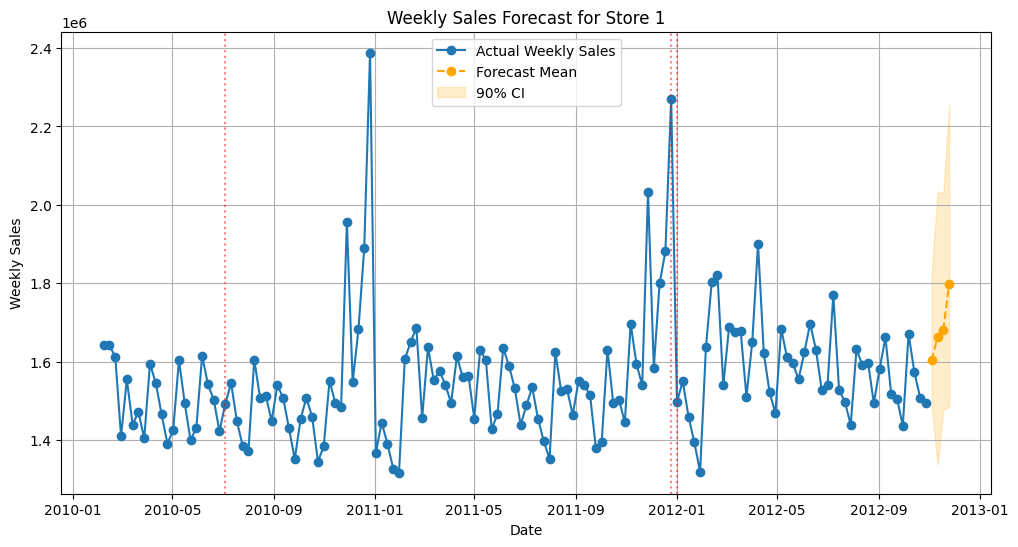

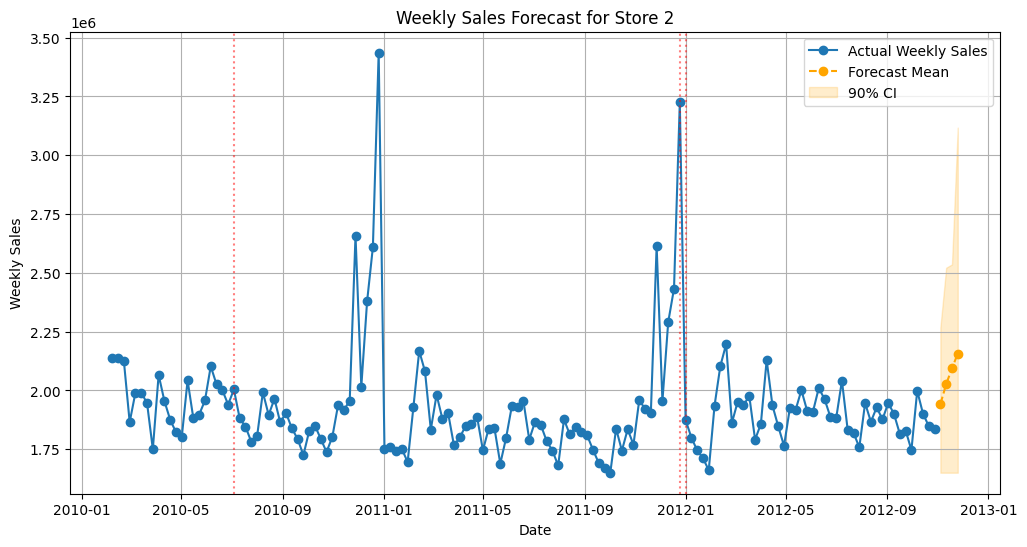

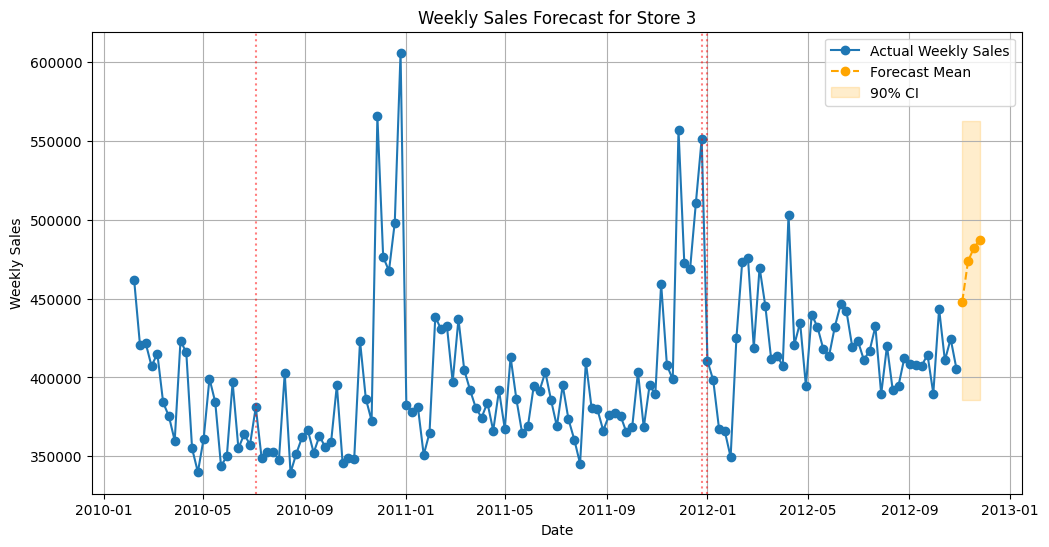

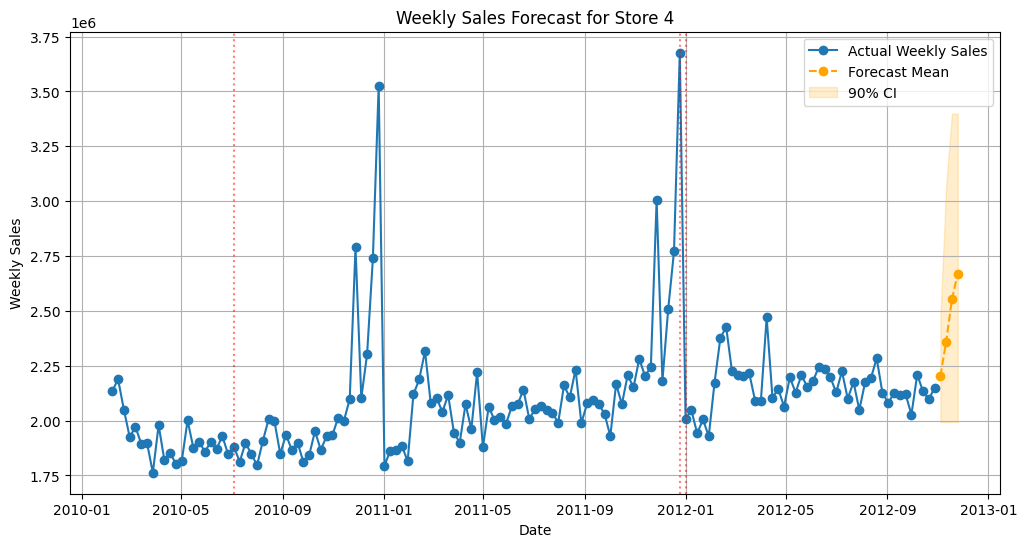

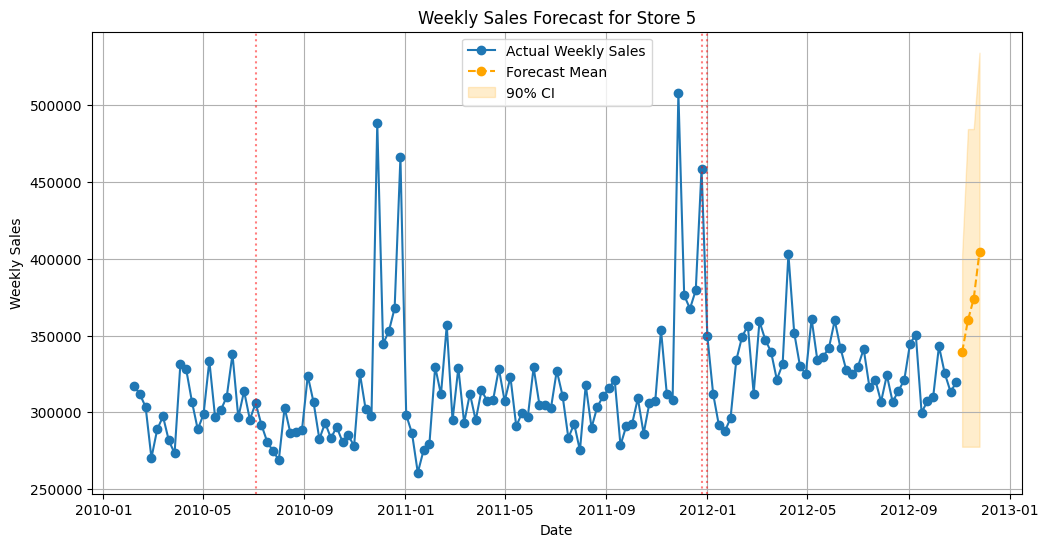

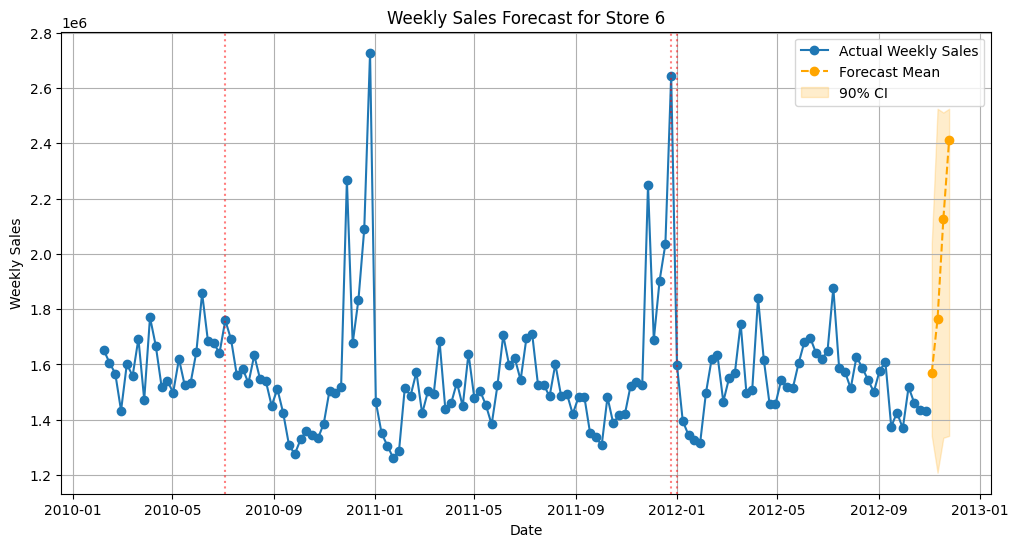

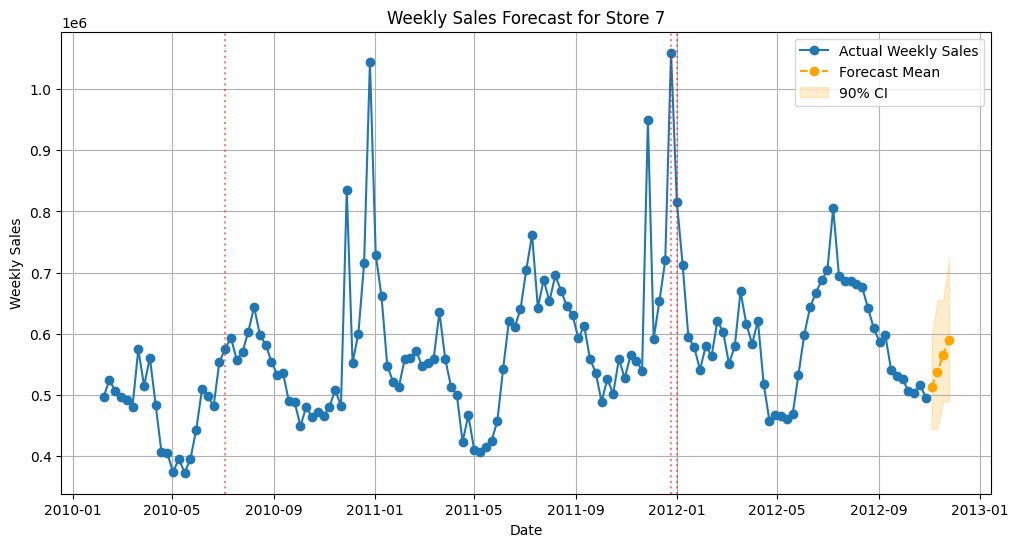

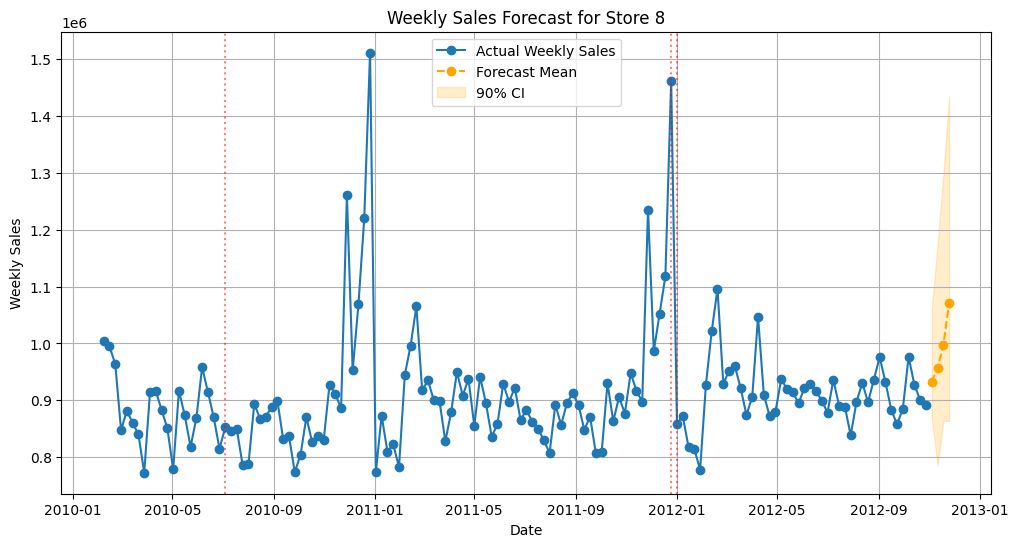

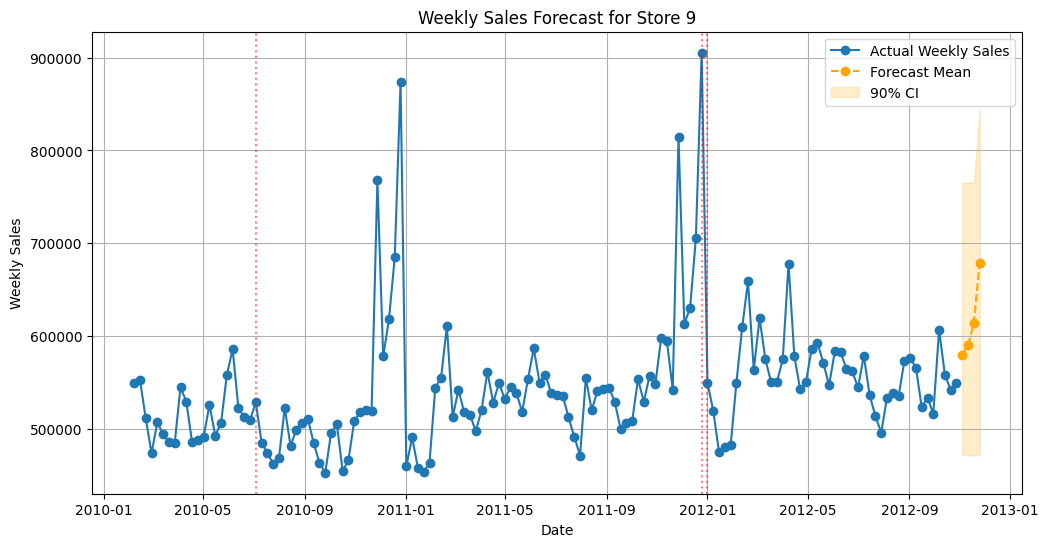

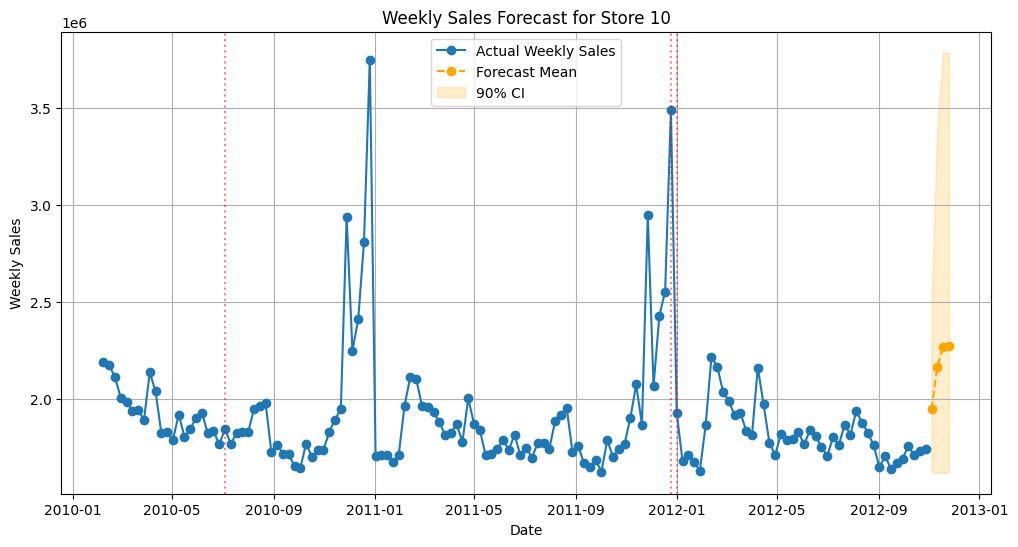

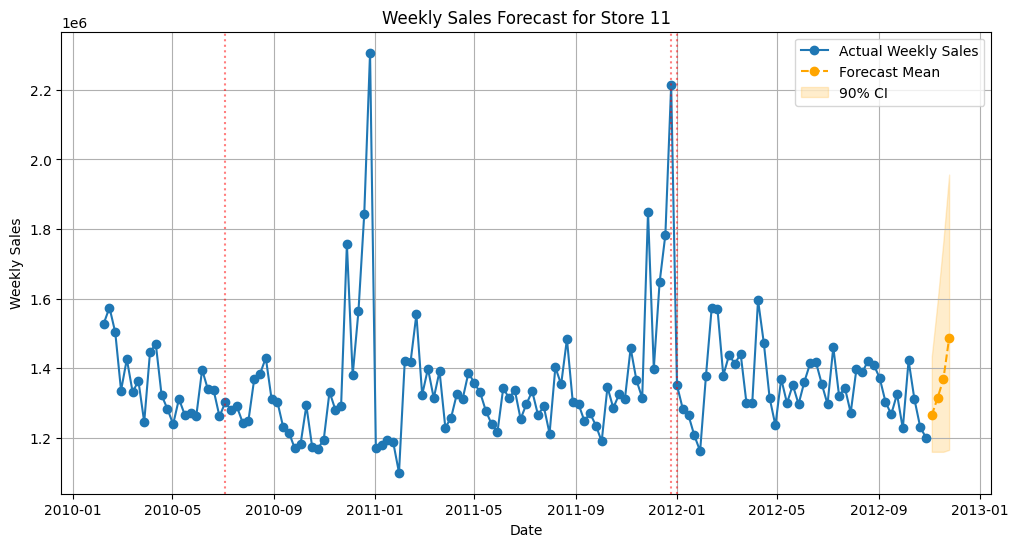

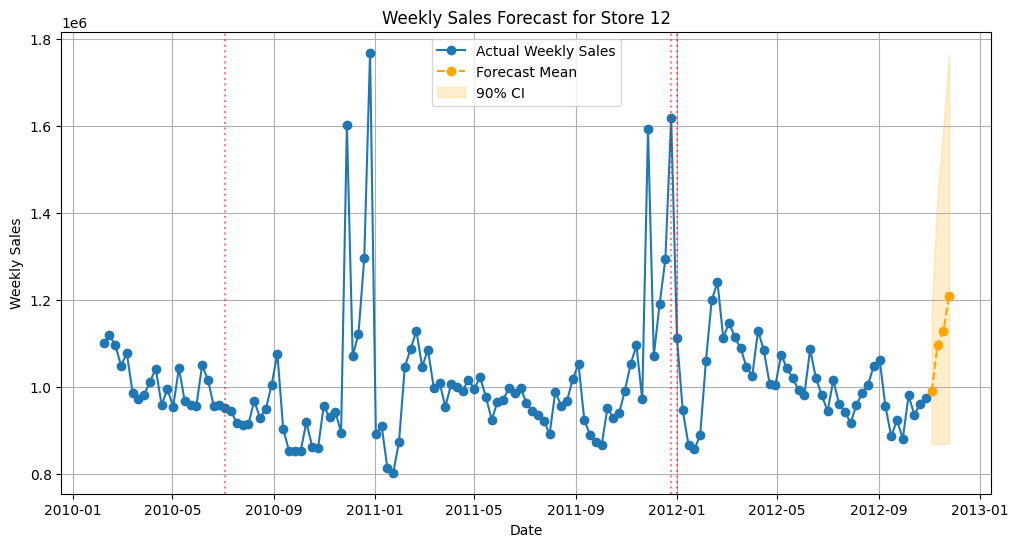

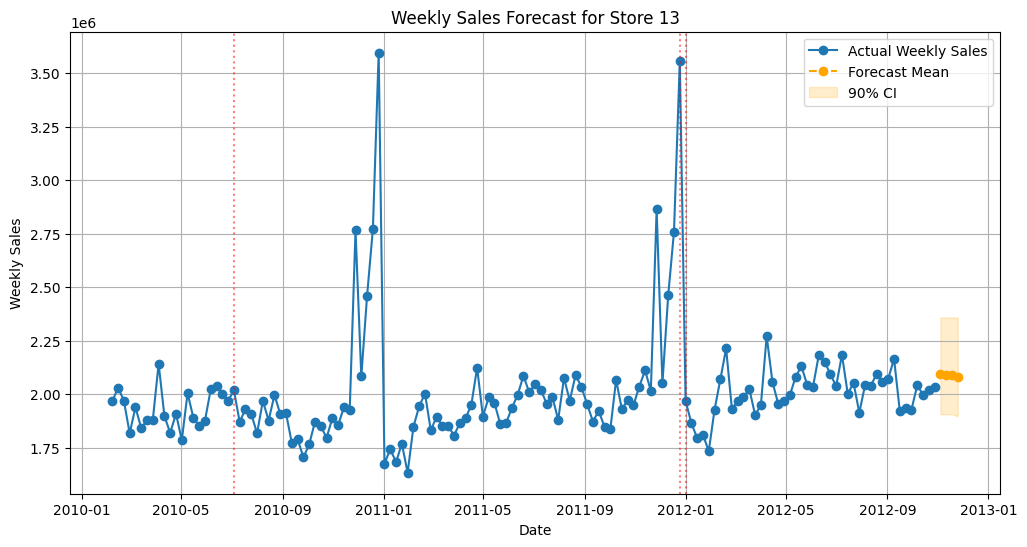

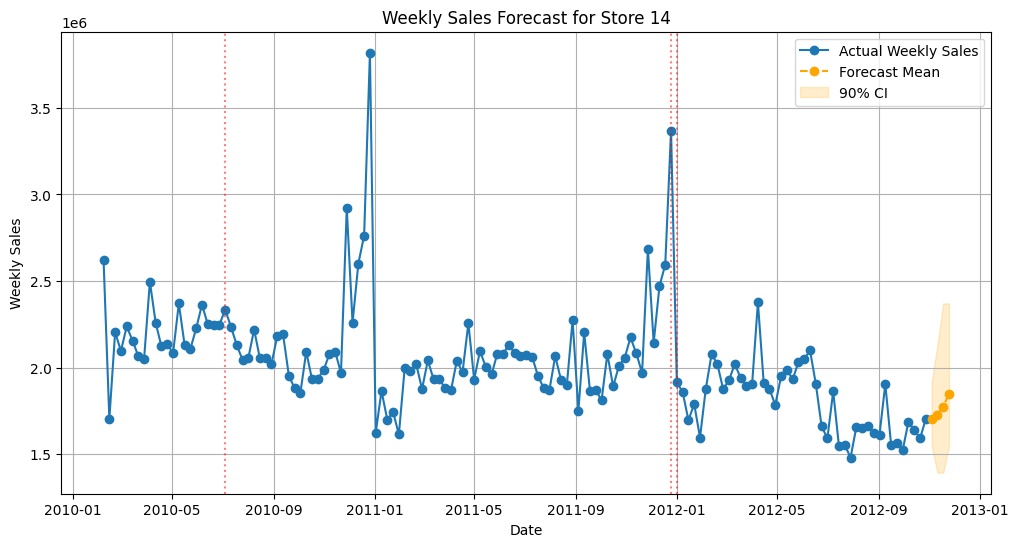

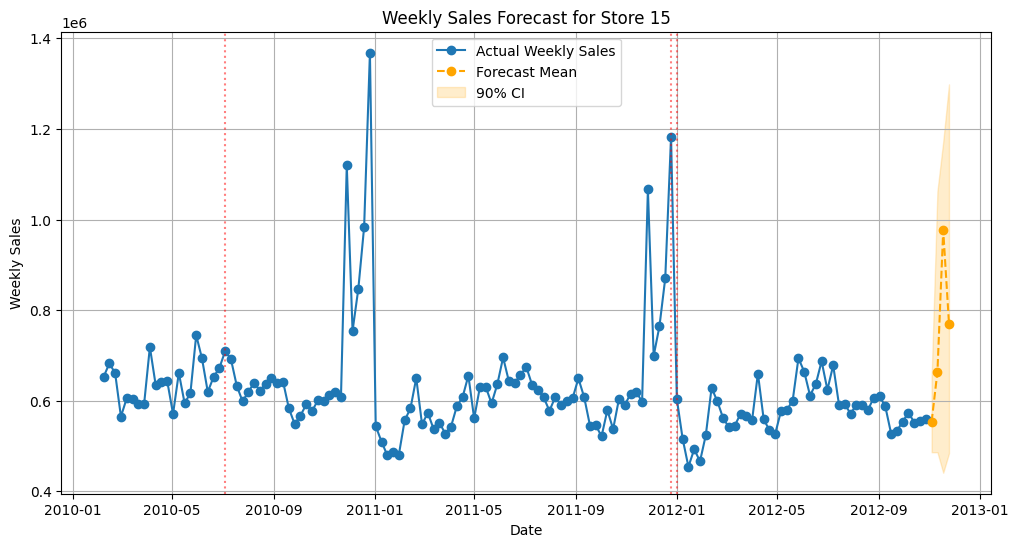

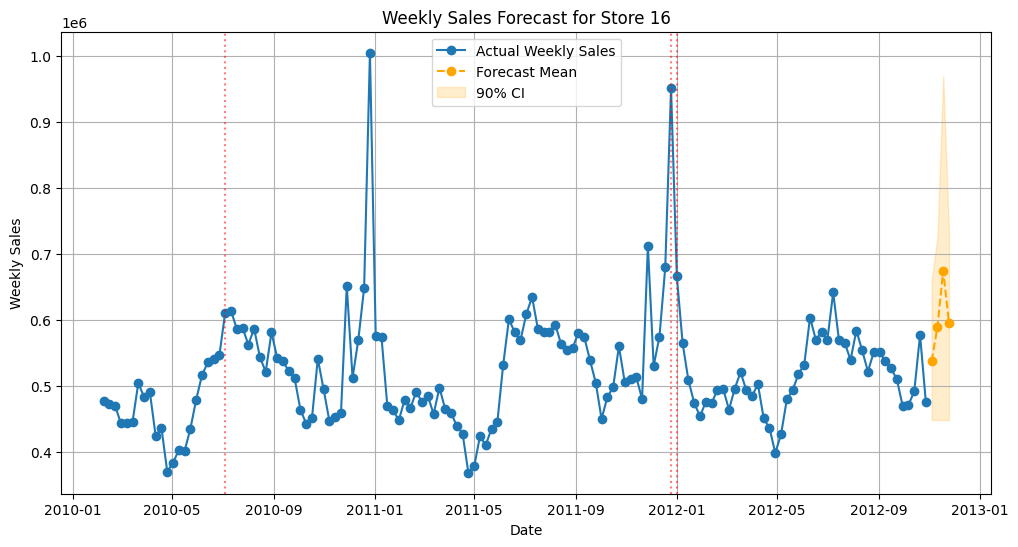

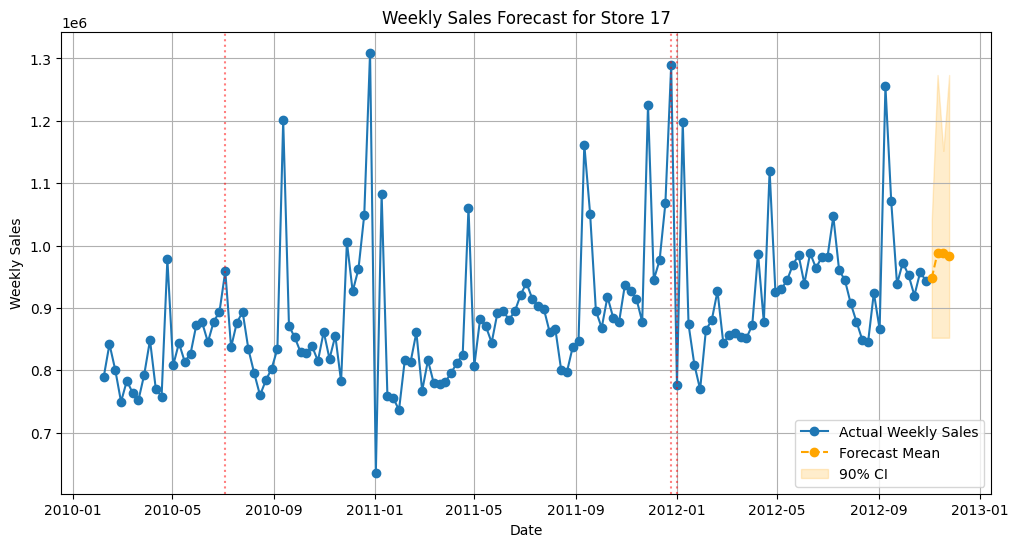

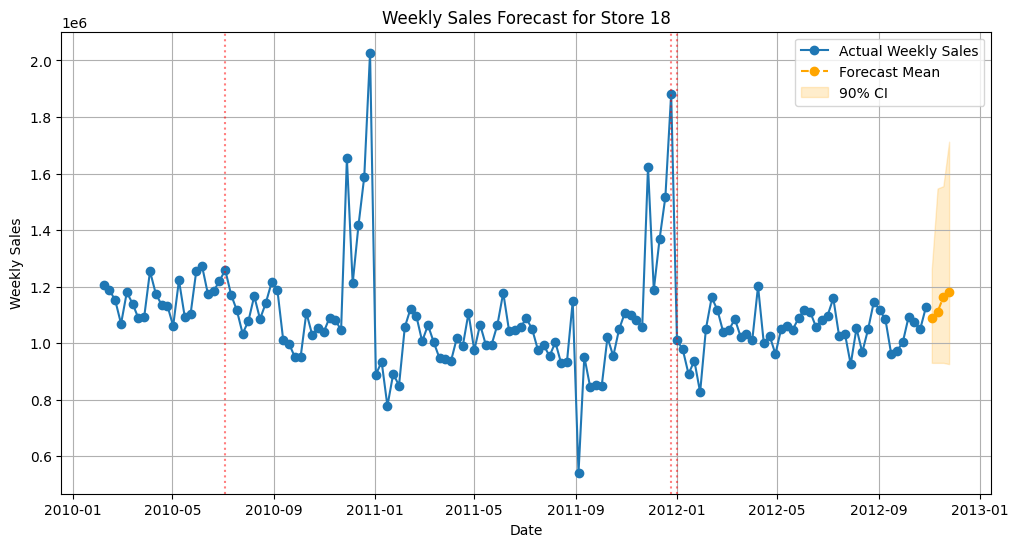

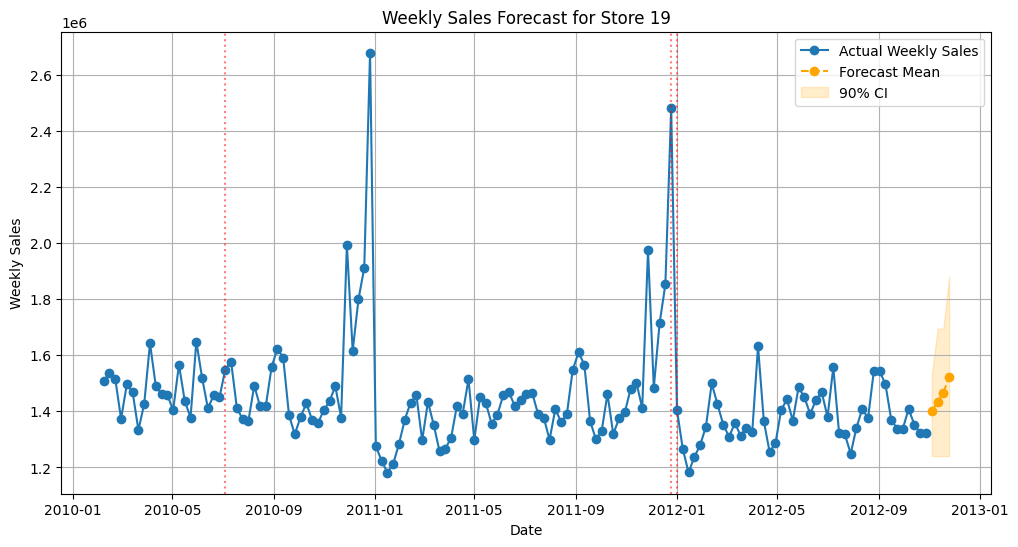

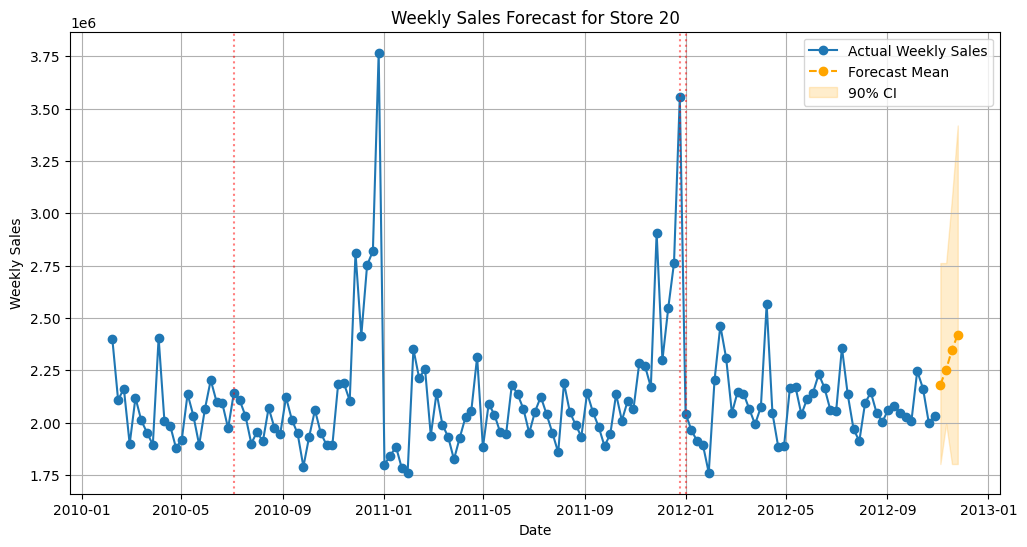

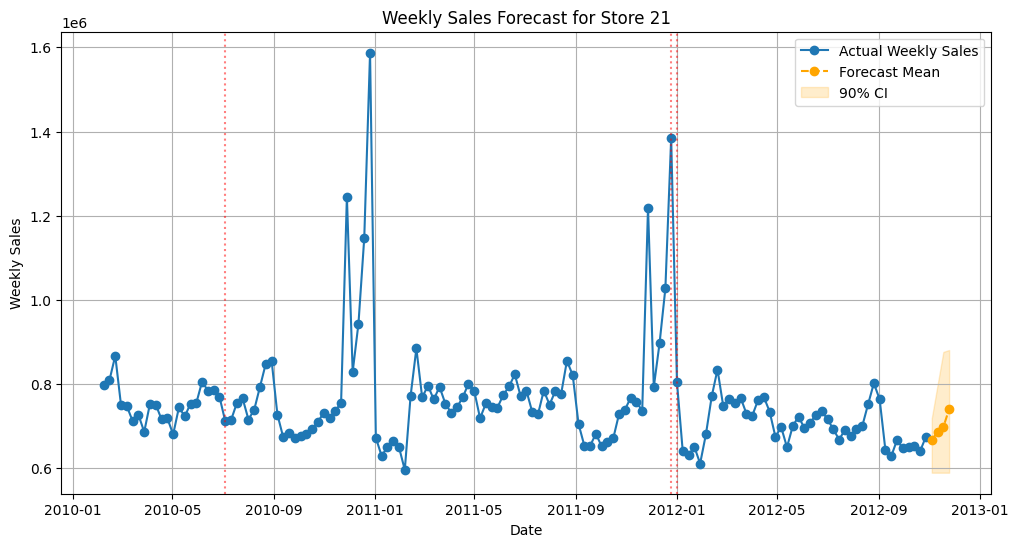

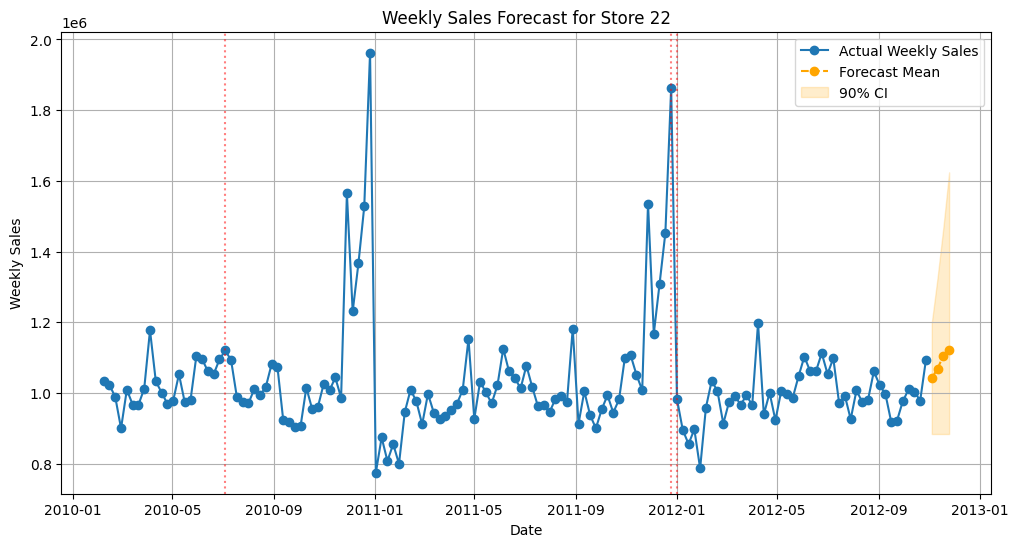

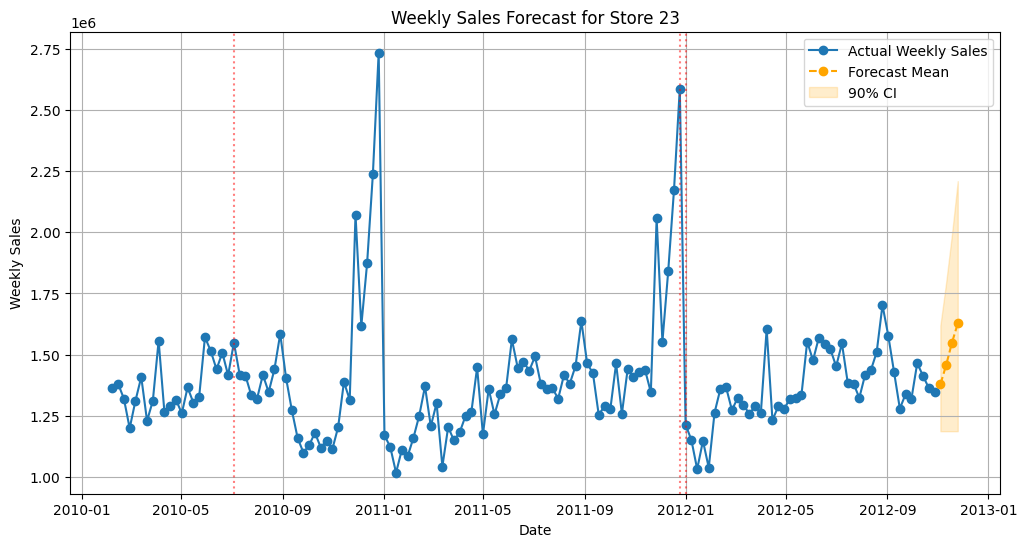

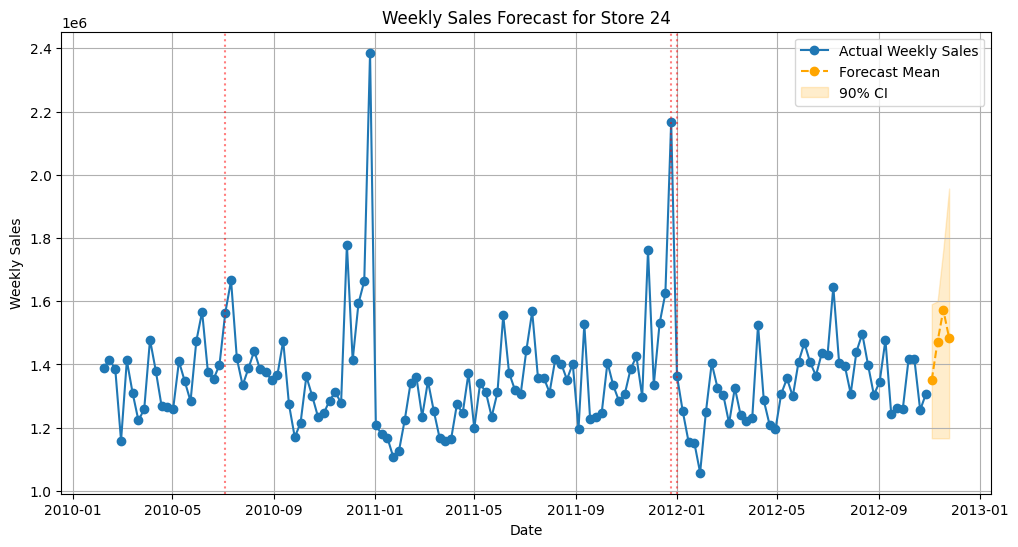

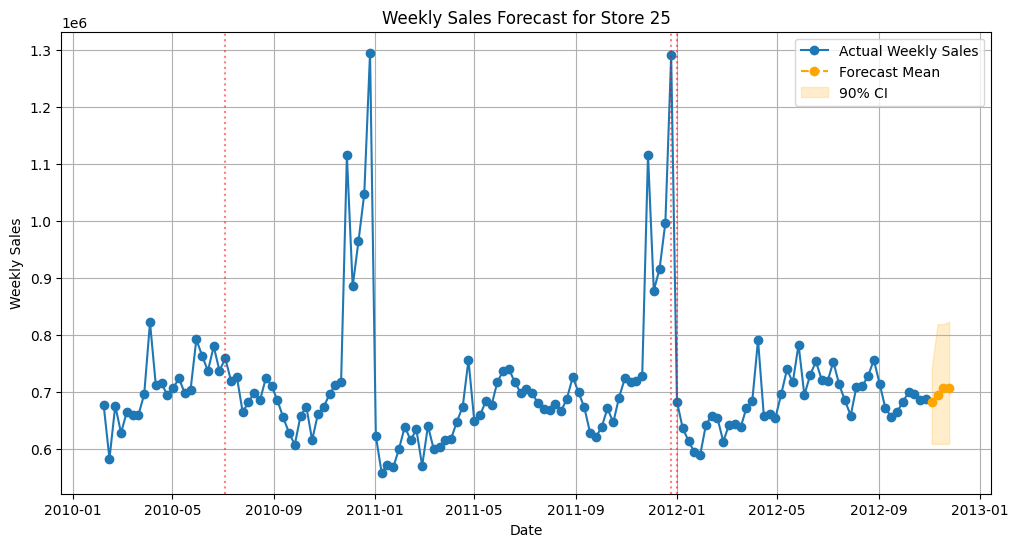

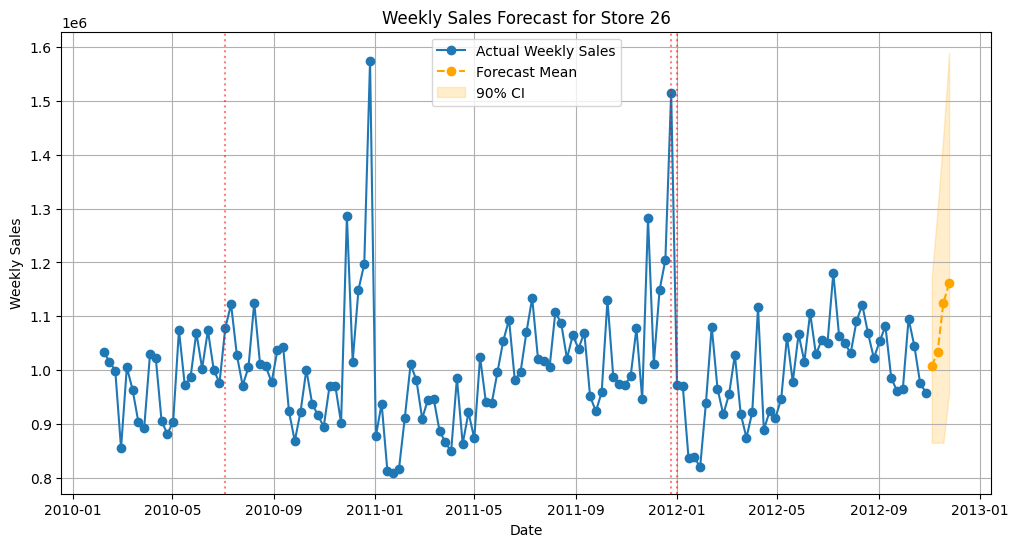

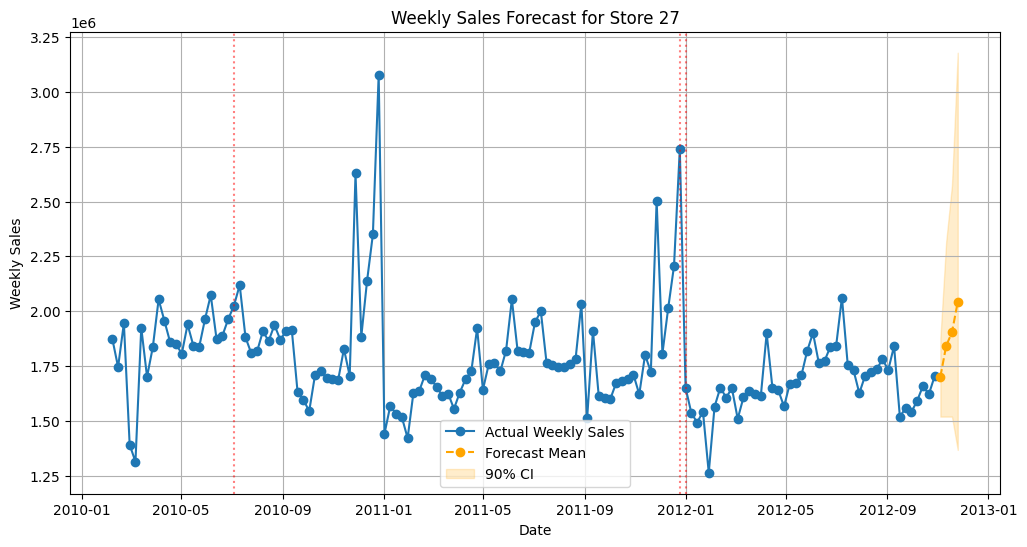

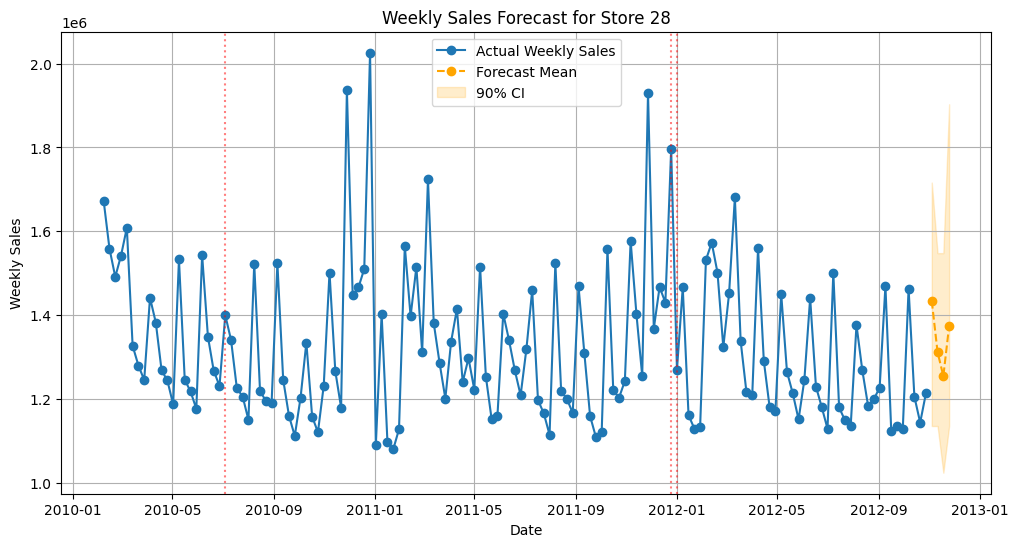

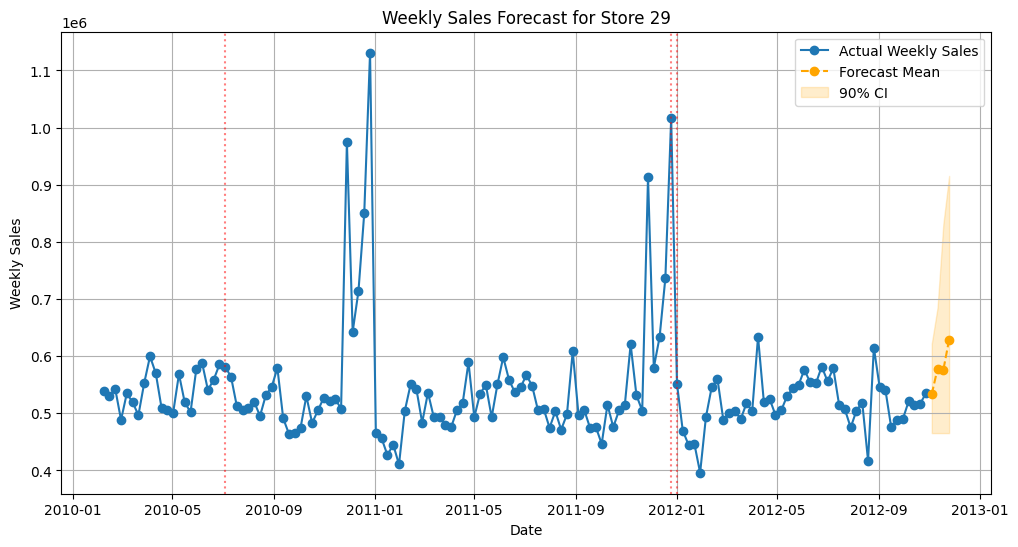

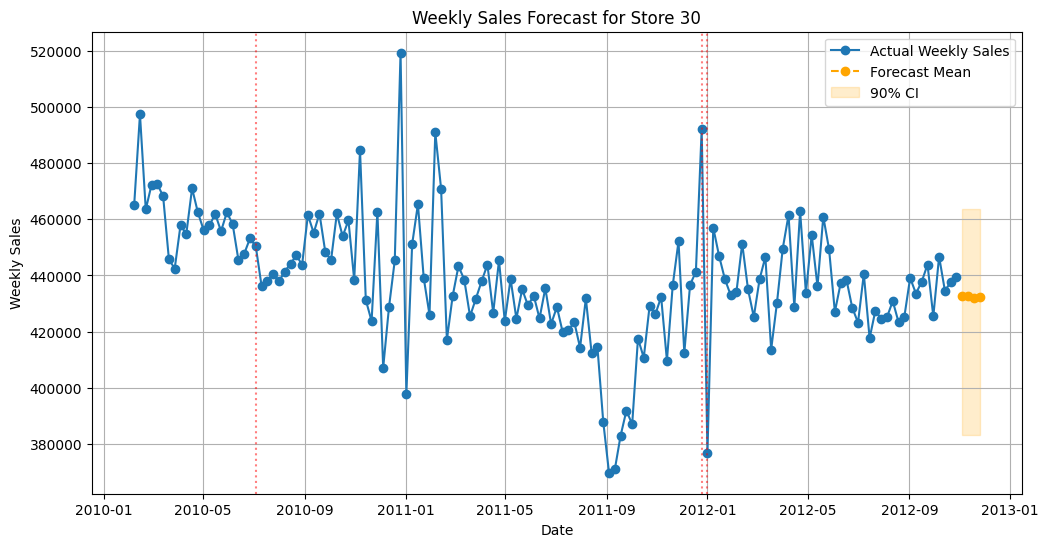

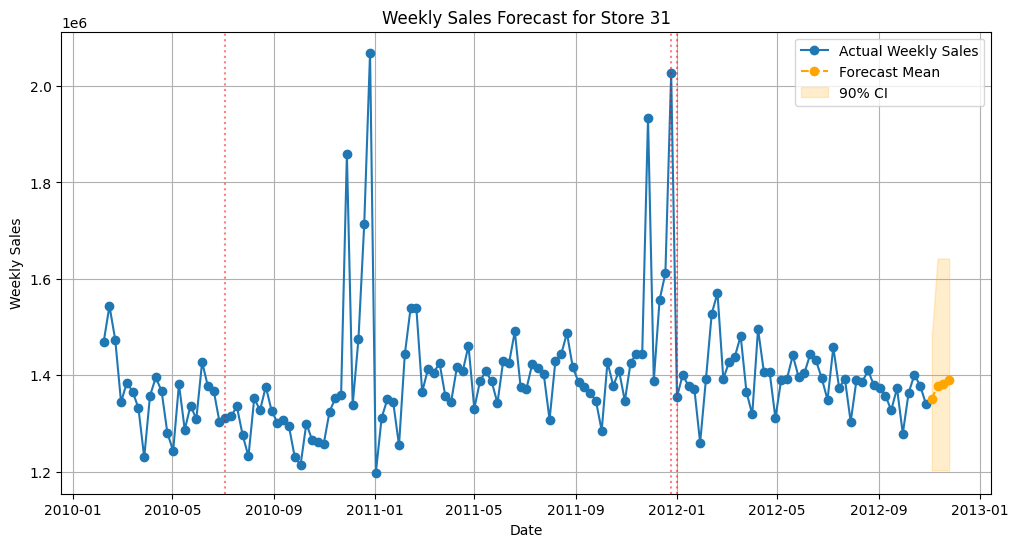

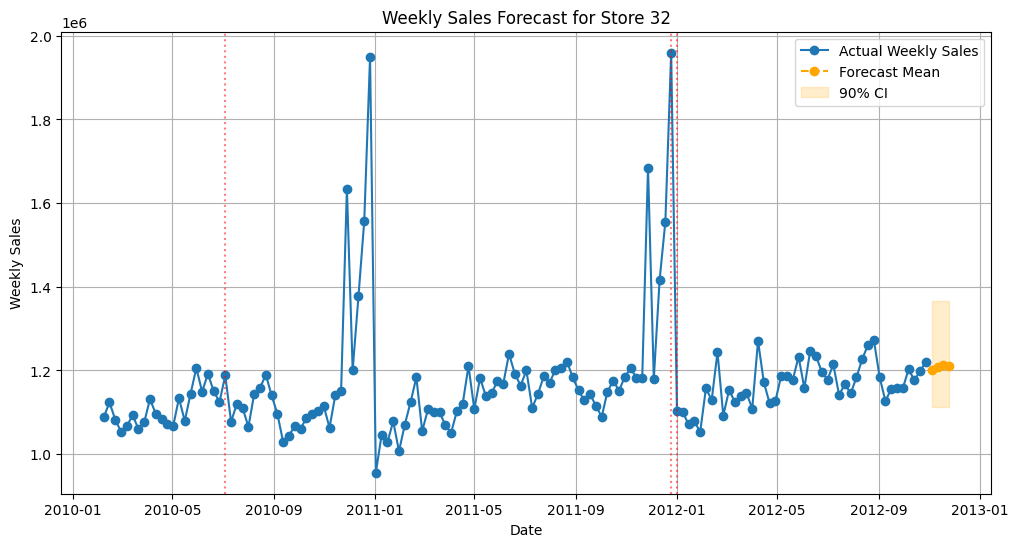

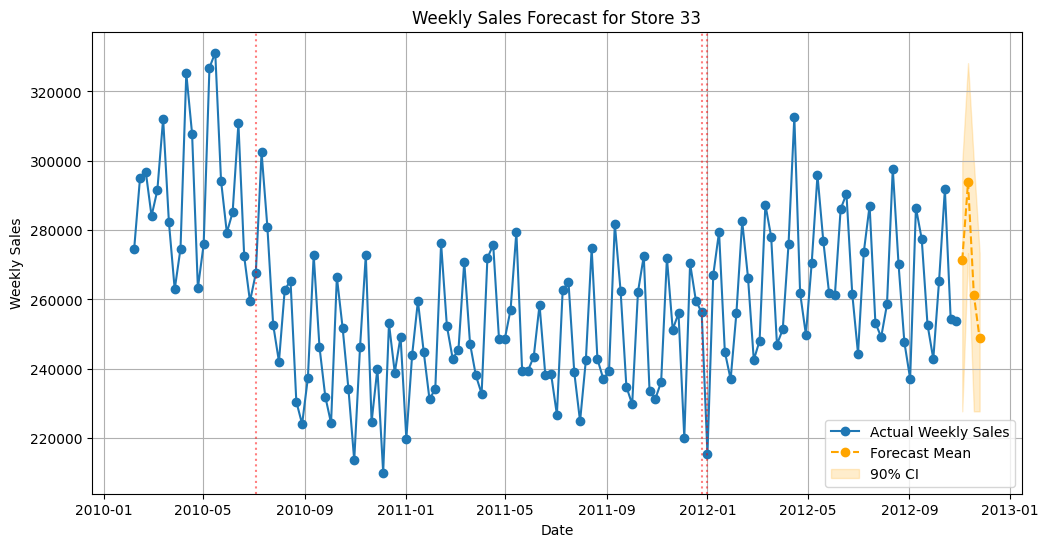

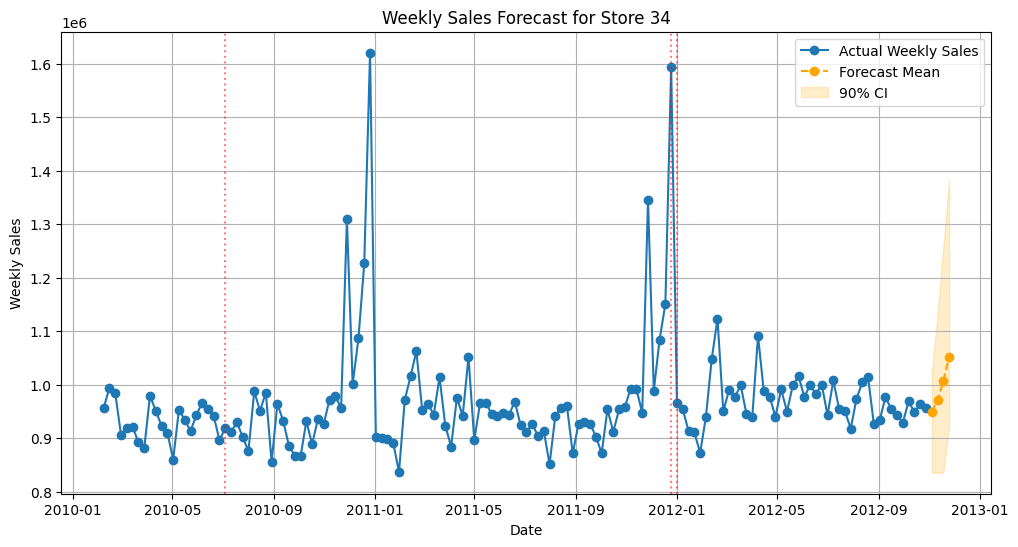

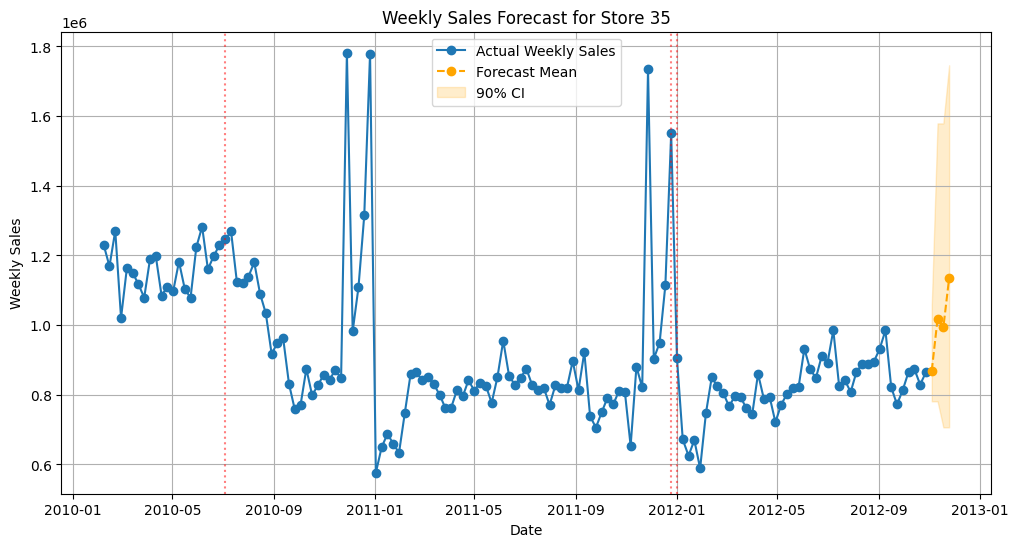

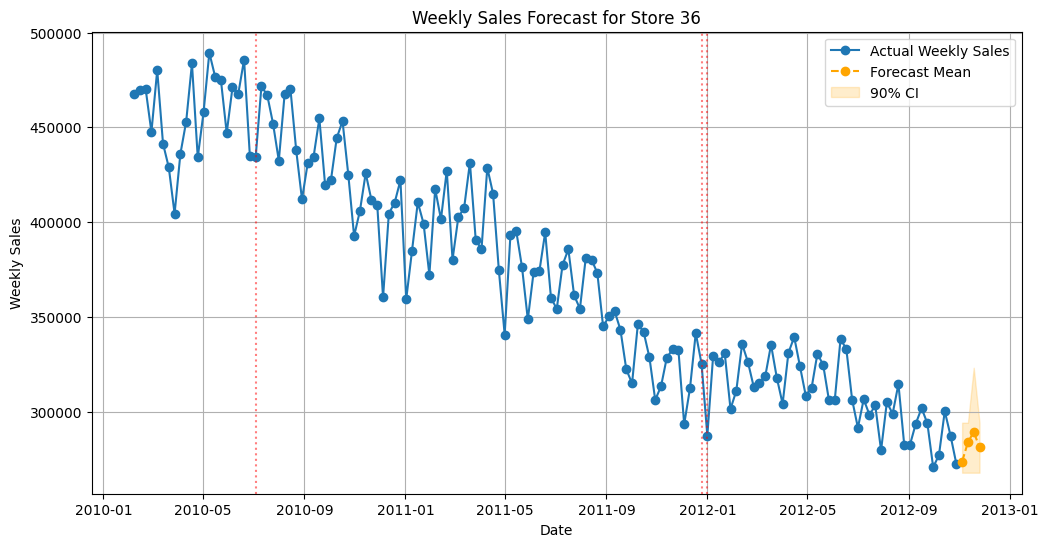

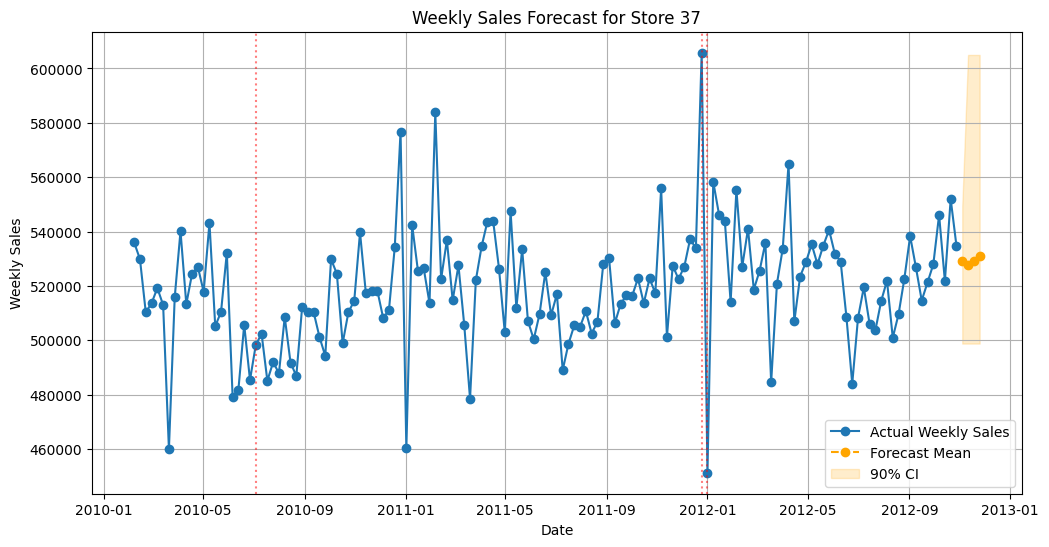

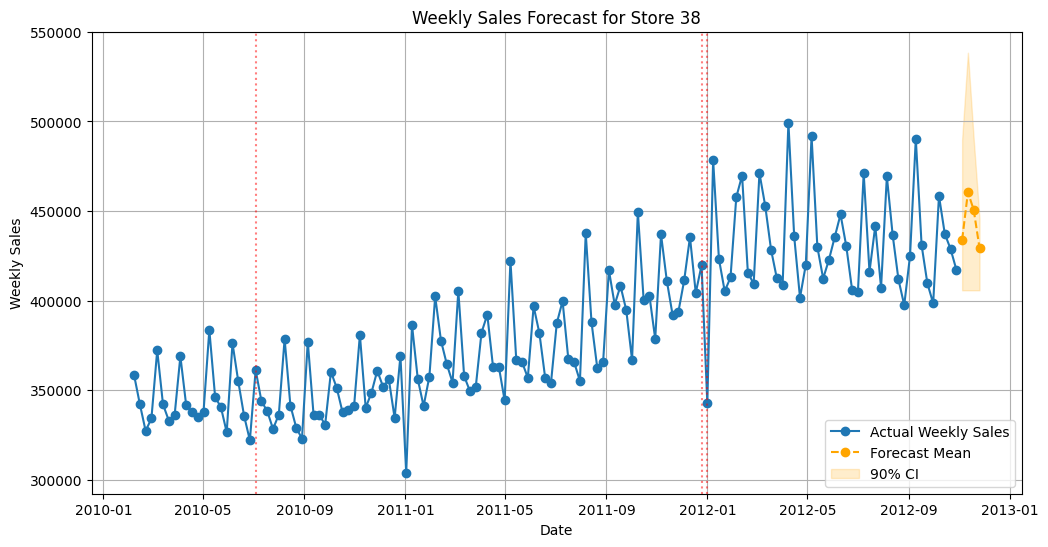

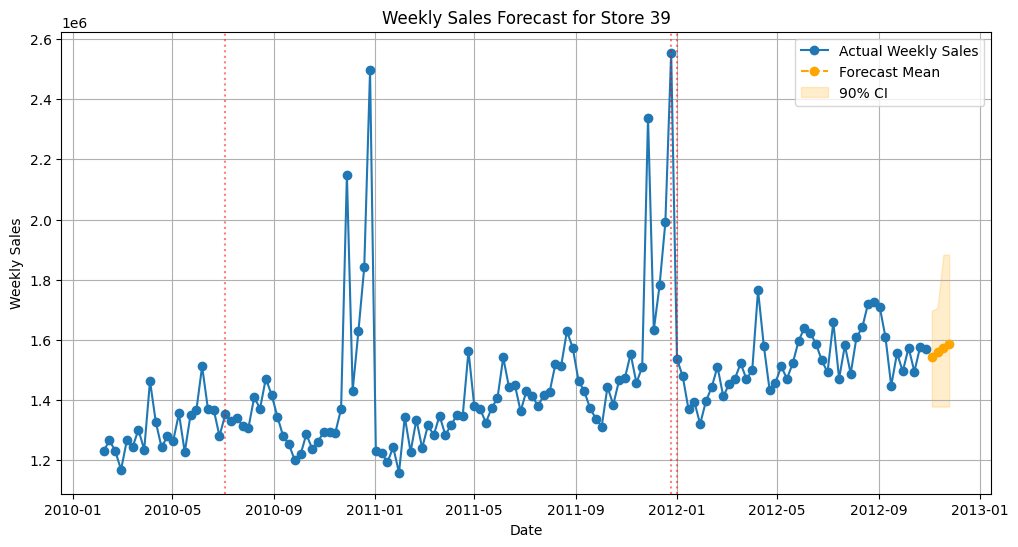

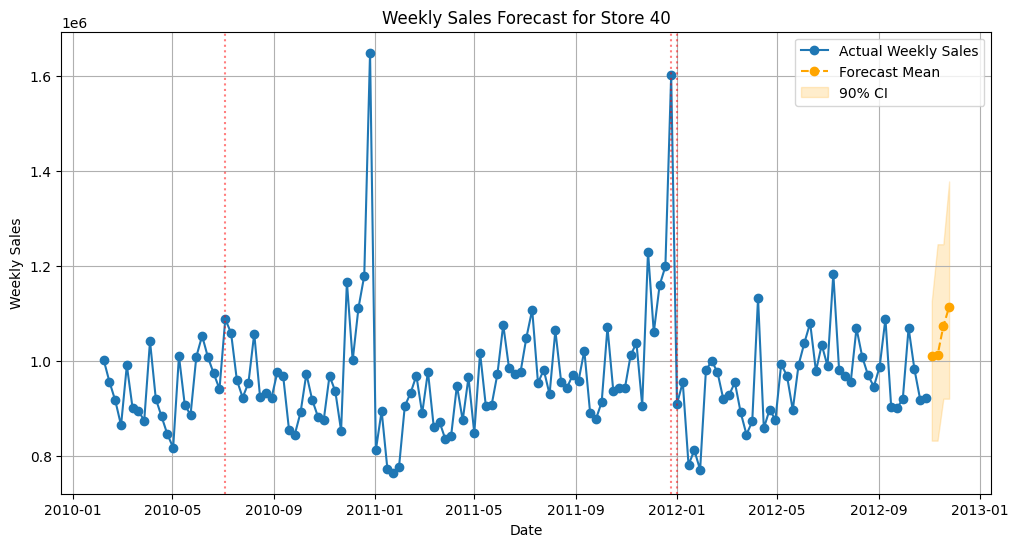

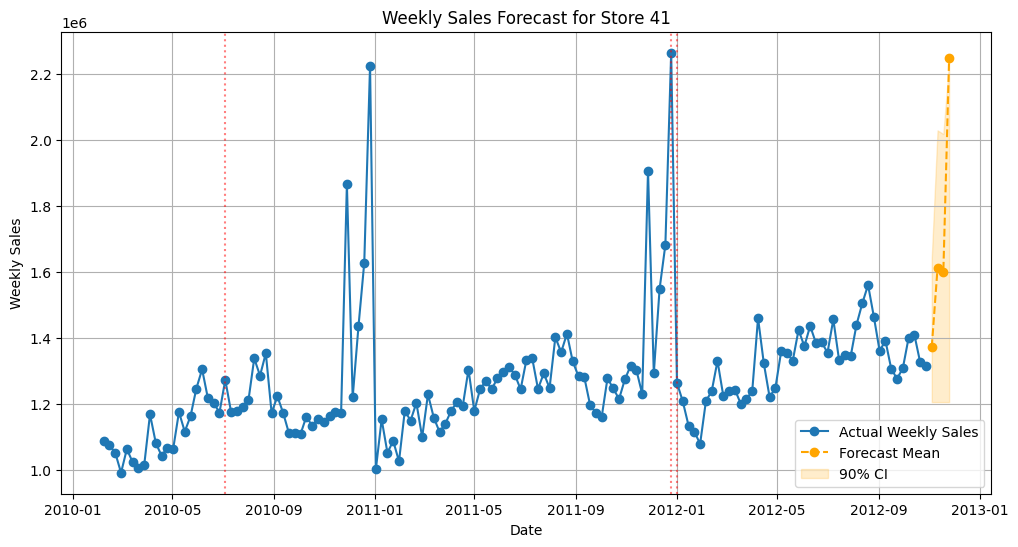

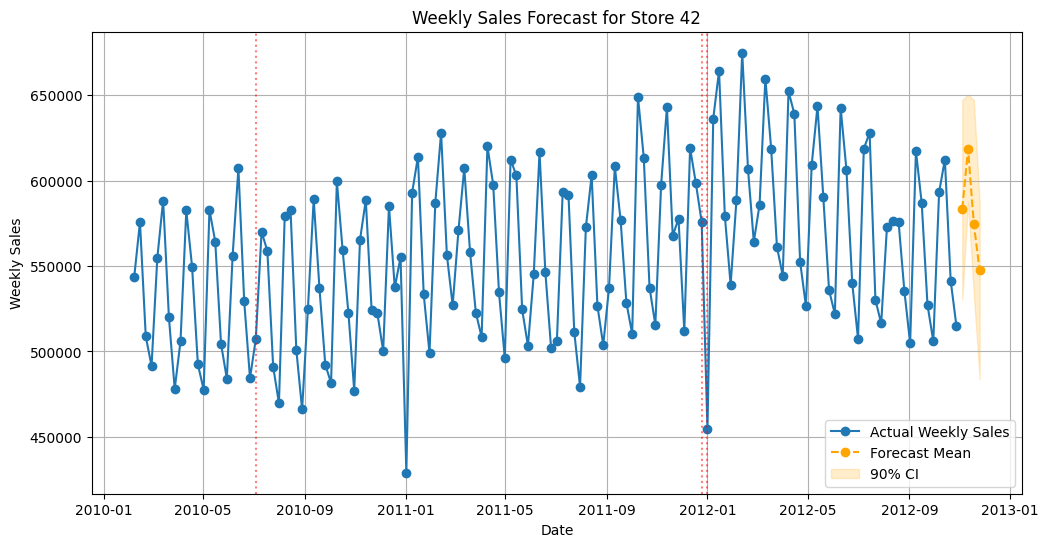

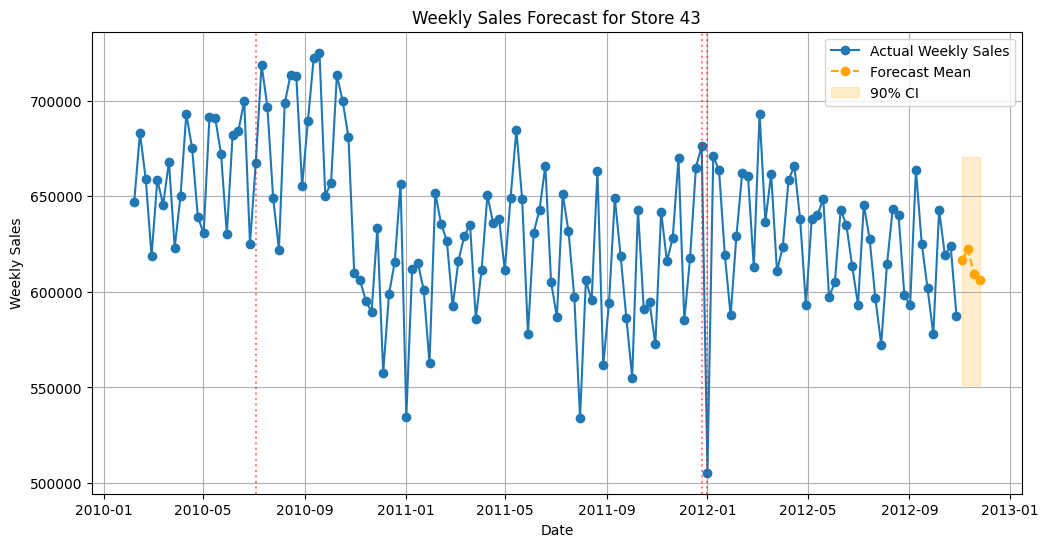

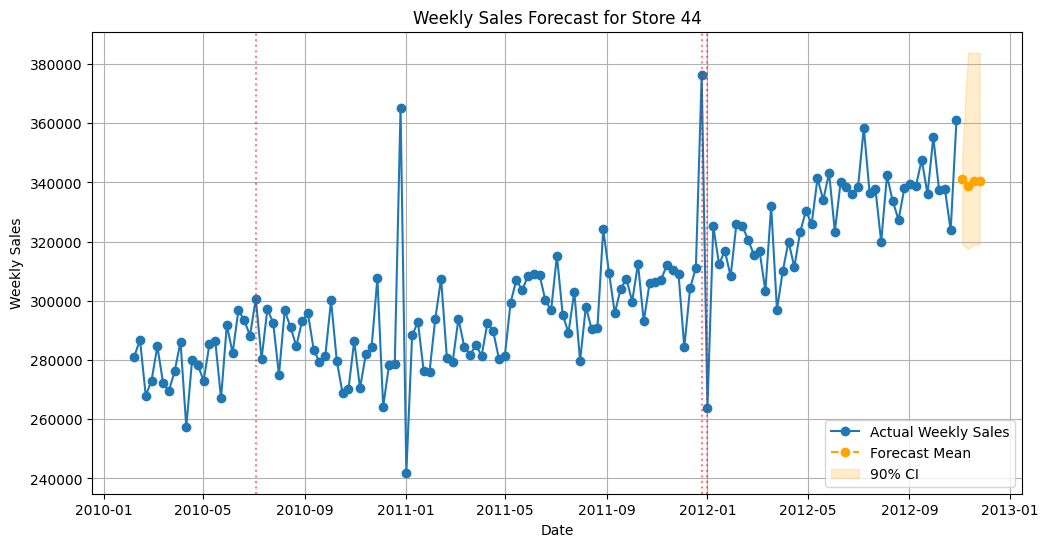

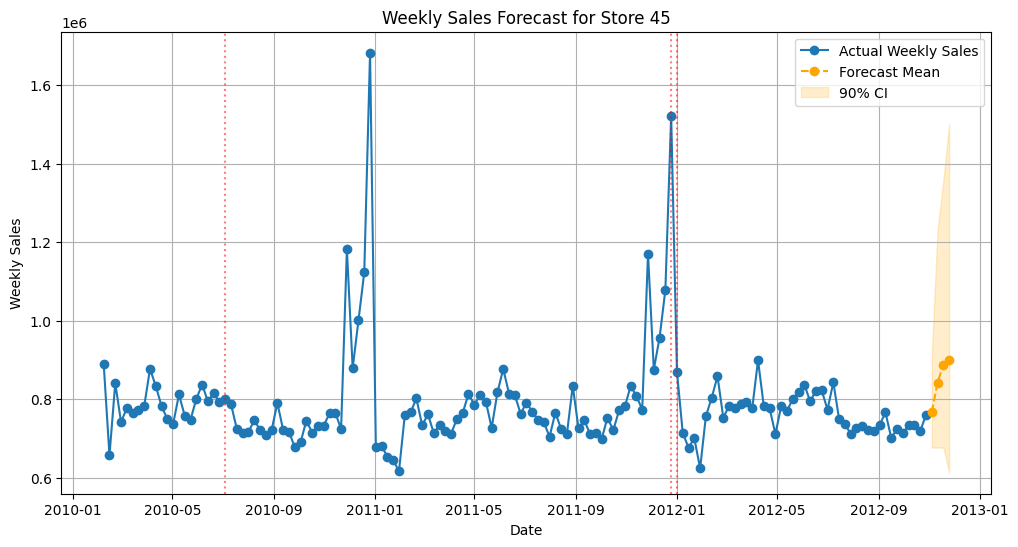

In [34]:
import matplotlib.pyplot as plt
import holidays

# US holidays for marking
us_holidays = holidays.US(years=[2023, 2024, 2025])  # add years as needed

for fc in all_store_forecasts:
    store_id = fc["store_id"]

    # Actual data for this store
    store_df = df_weekly[df_weekly["Store"] == store_id].sort_values("Date")

    # Forecast dates (next 4 weeks after last date)
    last_date = store_df["Date"].max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=prediction_length, freq='W')

    mean_fc = fc["mean"]
    low_fc = fc["low"]
    high_fc = fc["high"]

    plt.figure(figsize=(12,6))

    # Plot actual weekly sales
    plt.plot(store_df["Date"], store_df["Weekly_Sales"], label="Actual Weekly Sales", marker='o')

    # Plot forecast mean
    plt.plot(forecast_dates, mean_fc, '--', color='orange', label="Forecast Mean", marker='o')

    # Fill 90% CI
    plt.fill_between(forecast_dates, low_fc, high_fc, color='orange', alpha=0.2, label="90% CI")

    # Mark holidays
    for h in store_df["Date"]:
        if h in us_holidays:
            plt.axvline(h, color='red', linestyle=':', alpha=0.5)

    plt.title(f"Weekly Sales Forecast for Store {store_id}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid(True)
    plt.show()


### Evaluate Forecast Performance

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Helper: MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    # avoid division by zero
    y_true_safe = np.where(y_true == 0, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

print("=== Chronos Weekly Forecast Performance ===")

for fc in all_store_forecasts:
    store_id = fc["store_id"]

    # Actuals
    store_df = df_weekly[df_weekly["Store"] == store_id].sort_values("Date")
    actuals = store_df["Weekly_Sales"].values[-prediction_length:]

    # Forecast mean
    pred = fc["mean"]

    # Replace NaN or Inf with zeros (or you can use np.nanmean)
    actuals = np.nan_to_num(actuals, nan=0.0, posinf=0.0, neginf=0.0)
    pred = np.nan_to_num(pred, nan=0.0, posinf=0.0, neginf=0.0)

    # Compute metrics
    mae = mean_absolute_error(actuals, pred)
    rmse = np.sqrt(mean_squared_error(actuals, pred))
    mape = mean_absolute_percentage_error(actuals, pred)

    print(f"Store {store_id}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")


=== Chronos Weekly Forecast Performance ===
Store 1: MAE=163885.88, RMSE=189504.36, MAPE=10.73%
Store 2: MAE=617350.82, RMSE=1010196.57, MAPE=31.37%
Store 3: MAE=49480.70, RMSE=59303.20, MAPE=12.03%
Store 4: MAE=130104.98, RMSE=152796.78, MAPE=6.12%
Store 5: MAE=55126.80, RMSE=66511.76, MAPE=17.22%
Store 6: MAE=255834.34, RMSE=291203.53, MAPE=17.72%
Store 7: MAE=57910.74, RMSE=66863.34, MAPE=11.51%
Store 8: MAE=103678.35, RMSE=125590.31, MAPE=11.45%
Store 9: MAE=37890.40, RMSE=38959.50, MAPE=6.74%
Store 10: MAE=446223.07, RMSE=478536.27, MAPE=25.74%
Store 11: MAE=135850.79, RMSE=151743.48, MAPE=10.69%
Store 12: MAE=116766.86, RMSE=137565.78, MAPE=12.17%
Store 13: MAE=117032.00, RMSE=155908.97, MAPE=5.80%
Store 14: MAE=87293.00, RMSE=106318.37, MAPE=5.33%
Store 15: MAE=110045.00, RMSE=129800.18, MAPE=19.77%
Store 16: MAE=94363.27, RMSE=97642.22, MAPE=18.68%
Store 17: MAE=21577.63, RMSE=28973.02, MAPE=2.32%
Store 18: MAE=72070.30, RMSE=83862.48, MAPE=6.60%
Store 19: MAE=92238.92, RMSE=10

##Insights

####For several stores, the Chronos model demonstrated exceptional forecasting accuracy, as evidenced by very low Mean Absolute Percentage Error (MAPE) values. Notably, Store 30 achieved a MAPE of merely 1.91%, and Store 33 performed even better with a MAPE of 1.70%. These figures are highly encouraging, signifying that for these particular locations, the model's predictions deviated from actual sales by less than two percent on average. Such precision suggests that these stores likely exhibit more consistent and predictable sales patterns, or perhaps less volatility, making them ideal candidates for the Chronos model's current configuration. This high accuracy provides a solid foundation for operational planning and inventory management in these specific stores.



---

